In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 4,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_4_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 10:53 - loss: 0.0333 - STD: 2.6158e-04 - MAE: 0.1655

 10/632 [..............................] - ETA: 3s - loss: 0.0183 - STD: 2.4974e-04 - MAE: 0.1020   

 19/632 [..............................] - ETA: 3s - loss: 0.0150 - STD: 3.1431e-04 - MAE: 0.0951

 28/632 [>.............................] - ETA: 3s - loss: 0.0136 - STD: 3.6043e-04 - MAE: 0.0891

 37/632 [>.............................] - ETA: 3s - loss: 0.0127 - STD: 4.4054e-04 - MAE: 0.0869

 46/632 [=>............................] - ETA: 3s - loss: 0.0122 - STD: 5.2706e-04 - MAE: 0.0849

 55/632 [=>............................] - ETA: 3s - loss: 0.0118 - STD: 6.5652e-04 - MAE: 0.0840

 64/632 [==>...........................] - ETA: 3s - loss: 0.0115 - STD: 8.3651e-04 - MAE: 0.0830

 73/632 [==>...........................] - ETA: 3s - loss: 0.0113 - STD: 0.0011 - MAE: 0.0823    

 82/632 [==>...........................] - ETA: 3s - loss: 0.0111 - STD: 0.0016 - MAE: 0.0818

 89/632 [===>..........................] - ETA: 3s - loss: 0.0110 - STD: 0.0021 - MAE: 0.0812

 97/632 [===>..........................] - ETA: 3s - loss: 0.0108 - STD: 0.0031 - MAE: 0.0808

106/632 [====>.........................] - ETA: 3s - loss: 0.0106 - STD: 0.0049 - MAE: 0.0801

115/632 [====>.........................] - ETA: 3s - loss: 0.0104 - STD: 0.0071 - MAE: 0.0794

120/632 [====>.........................] - ETA: 3s - loss: 0.0103 - STD: 0.0084 - MAE: 0.0790

127/632 [=====>........................] - ETA: 3s - loss: 0.0102 - STD: 0.0099 - MAE: 0.0784

135/632 [=====>........................] - ETA: 3s - loss: 0.0101 - STD: 0.0117 - MAE: 0.0779

144/632 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 0.0136 - MAE: 0.0773

152/632 [======>.......................] - ETA: 3s - loss: 0.0098 - STD: 0.0151 - MAE: 0.0768

161/632 [======>.......................] - ETA: 3s - loss: 0.0097 - STD: 0.0169 - MAE: 0.0762

170/632 [=======>......................] - ETA: 2s - loss: 0.0095 - STD: 0.0184 - MAE: 0.0756

178/632 [=======>......................] - ETA: 2s - loss: 0.0094 - STD: 0.0196 - MAE: 0.0750

185/632 [=======>......................] - ETA: 2s - loss: 0.0093 - STD: 0.0209 - MAE: 0.0745

192/632 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 0.0223 - MAE: 0.0739

199/632 [========>.....................] - ETA: 2s - loss: 0.0091 - STD: 0.0236 - MAE: 0.0734

207/632 [========>.....................] - ETA: 2s - loss: 0.0090 - STD: 0.0250 - MAE: 0.0729

215/632 [=========>....................] - ETA: 2s - loss: 0.0089 - STD: 0.0263 - MAE: 0.0724

222/632 [=========>....................] - ETA: 2s - loss: 0.0088 - STD: 0.0273 - MAE: 0.0720

229/632 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.0283 - MAE: 0.0715

236/632 [==========>...................] - ETA: 2s - loss: 0.0086 - STD: 0.0293 - MAE: 0.0711

244/632 [==========>...................] - ETA: 2s - loss: 0.0085 - STD: 0.0304 - MAE: 0.0707

252/632 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.0314 - MAE: 0.0702

259/632 [===========>..................] - ETA: 2s - loss: 0.0083 - STD: 0.0322 - MAE: 0.0698

267/632 [===========>..................] - ETA: 2s - loss: 0.0083 - STD: 0.0332 - MAE: 0.0693

274/632 [============>.................] - ETA: 2s - loss: 0.0082 - STD: 0.0340 - MAE: 0.0690

282/632 [============>.................] - ETA: 2s - loss: 0.0081 - STD: 0.0349 - MAE: 0.0686

289/632 [============>.................] - ETA: 2s - loss: 0.0080 - STD: 0.0356 - MAE: 0.0682

296/632 [=============>................] - ETA: 2s - loss: 0.0080 - STD: 0.0363 - MAE: 0.0679

303/632 [=============>................] - ETA: 2s - loss: 0.0079 - STD: 0.0370 - MAE: 0.0676

310/632 [=============>................] - ETA: 2s - loss: 0.0079 - STD: 0.0376 - MAE: 0.0673

317/632 [==============>...............] - ETA: 2s - loss: 0.0078 - STD: 0.0382 - MAE: 0.0670

324/632 [==============>...............] - ETA: 2s - loss: 0.0077 - STD: 0.0389 - MAE: 0.0667

332/632 [==============>...............] - ETA: 2s - loss: 0.0077 - STD: 0.0395 - MAE: 0.0664

340/632 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.0401 - MAE: 0.0662

347/632 [===============>..............] - ETA: 1s - loss: 0.0076 - STD: 0.0406 - MAE: 0.0659

355/632 [===============>..............] - ETA: 1s - loss: 0.0075 - STD: 0.0412 - MAE: 0.0656

362/632 [================>.............] - ETA: 1s - loss: 0.0075 - STD: 0.0416 - MAE: 0.0654

368/632 [================>.............] - ETA: 1s - loss: 0.0074 - STD: 0.0420 - MAE: 0.0652

374/632 [================>.............] - ETA: 1s - loss: 0.0074 - STD: 0.0425 - MAE: 0.0650

379/632 [================>.............] - ETA: 1s - loss: 0.0074 - STD: 0.0428 - MAE: 0.0649

385/632 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.0432 - MAE: 0.0647

392/632 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.0437 - MAE: 0.0644

399/632 [=================>............] - ETA: 1s - loss: 0.0073 - STD: 0.0441 - MAE: 0.0642

406/632 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.0445 - MAE: 0.0640

413/632 [==================>...........] - ETA: 1s - loss: 0.0072 - STD: 0.0449 - MAE: 0.0639

420/632 [==================>...........] - ETA: 1s - loss: 0.0071 - STD: 0.0452 - MAE: 0.0637

427/632 [===================>..........] - ETA: 1s - loss: 0.0071 - STD: 0.0456 - MAE: 0.0635

434/632 [===================>..........] - ETA: 1s - loss: 0.0071 - STD: 0.0460 - MAE: 0.0633

442/632 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0464 - MAE: 0.0631

451/632 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0469 - MAE: 0.0628

458/632 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0472 - MAE: 0.0627

469/632 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.0477 - MAE: 0.0624

478/632 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.0481 - MAE: 0.0622

487/632 [======================>.......] - ETA: 1s - loss: 0.0068 - STD: 0.0485 - MAE: 0.0620

496/632 [======================>.......] - ETA: 1s - loss: 0.0068 - STD: 0.0489 - MAE: 0.0618

505/632 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0493 - MAE: 0.0617

513/632 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0496 - MAE: 0.0615

521/632 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0499 - MAE: 0.0613

528/632 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0502 - MAE: 0.0612

536/632 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0505 - MAE: 0.0611

544/632 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0508 - MAE: 0.0610

552/632 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0510 - MAE: 0.0609

561/632 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0512 - MAE: 0.0608

567/632 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0514 - MAE: 0.0607

574/632 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0516 - MAE: 0.0606

582/632 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0518 - MAE: 0.0605

591/632 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0521 - MAE: 0.0604

600/632 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0523 - MAE: 0.0602

609/632 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0526 - MAE: 0.0601

618/632 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0529 - MAE: 0.0599

627/632 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0531 - MAE: 0.0598

632/632 [==============================] - 6s 9ms/step - loss: 0.0064 - STD: 0.0533 - MAE: 0.0597 - val_loss: 0.0045 - val_STD: 0.0599 - val_MAE: 0.0513


Epoch 2/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0051 - STD: 0.0756 - MAE: 0.0557

  9/632 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0720 - MAE: 0.0520 

 18/632 [..............................] - ETA: 3s - loss: 0.0048 - STD: 0.0712 - MAE: 0.0513

 27/632 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0721 - MAE: 0.0515

 36/632 [>.............................] - ETA: 3s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0512

 45/632 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0708 - MAE: 0.0513

 53/632 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0709 - MAE: 0.0512

 62/632 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0511

 71/632 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0711 - MAE: 0.0509

 80/632 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0717 - MAE: 0.0508

 89/632 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0507

 98/632 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0506

107/632 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0506

116/632 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0505

125/632 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0720 - MAE: 0.0505

133/632 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0505

141/632 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0504

149/632 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0502

158/632 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0503

166/632 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0723 - MAE: 0.0502

174/632 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0502

183/632 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0502

192/632 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0721 - MAE: 0.0502

201/632 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0501

210/632 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0500

219/632 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

227/632 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

236/632 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

244/632 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

252/632 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0500

261/632 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0499

270/632 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

279/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

288/632 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

297/632 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

306/632 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

314/632 [=============>................] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

322/632 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0499

331/632 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498

340/632 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

348/632 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0725 - MAE: 0.0498

357/632 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

366/632 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0726 - MAE: 0.0498

375/632 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0727 - MAE: 0.0497

384/632 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

393/632 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

402/632 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

411/632 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0497

420/632 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

429/632 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

438/632 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0496

447/632 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0728 - MAE: 0.0496

456/632 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0496

465/632 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0729 - MAE: 0.0496

474/632 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

483/632 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

492/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

501/632 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

510/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

519/632 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

528/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

537/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

546/632 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0495

555/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

563/632 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

572/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0494

581/632 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0494

590/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

599/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

608/632 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0730 - MAE: 0.0493

617/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

626/632 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493

632/632 [==============================] - 4s 6ms/step - loss: 0.0044 - STD: 0.0731 - MAE: 0.0493 - val_loss: 0.0040 - val_STD: 0.0523 - val_MAE: 0.0458


Epoch 3/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0045 - STD: 0.0693 - MAE: 0.0483

  8/632 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0704 - MAE: 0.0493 

 17/632 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0720 - MAE: 0.0484

 26/632 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486

 35/632 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0483

 44/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0480

 53/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0740 - MAE: 0.0479

 62/632 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0479

 71/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479

 79/632 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478

 88/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

 97/632 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

106/632 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0477

115/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0479

123/632 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0478

132/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478

141/632 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0478

150/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0477

159/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0477

168/632 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477

177/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477

186/632 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

195/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

203/632 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

211/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

220/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

229/632 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476

238/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

247/632 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

256/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

265/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

273/632 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

282/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

291/632 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

300/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

309/632 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

318/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

326/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

335/632 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

344/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

352/632 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0473

359/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

367/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

376/632 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

384/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0475

393/632 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

401/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

409/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476

417/632 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

425/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

433/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0475

442/632 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475

451/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0474

459/632 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

467/632 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0753 - MAE: 0.0474

475/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

483/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

492/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

501/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

510/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

519/632 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474

528/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474

537/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

545/632 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

553/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

562/632 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

571/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473

580/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473

588/632 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

596/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

604/632 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

613/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

621/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472

630/632 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472

632/632 [==============================] - 4s 7ms/step - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472 - val_loss: 0.0037 - val_STD: 0.0638 - val_MAE: 0.0454


Epoch 4/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0446

  9/632 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0774 - MAE: 0.0455 

 18/632 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0458

 27/632 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0459

 36/632 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0459

 45/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0458

 54/632 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0458

 63/632 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0460

 72/632 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459

 81/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0459

 90/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

 99/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0457

108/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0457

117/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0457

126/632 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460

135/632 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0461

144/632 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461

153/632 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460

162/632 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

171/632 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0459

180/632 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

189/632 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460

198/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

207/632 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

216/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

224/632 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

233/632 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

242/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0459

251/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0459

260/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

269/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

278/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0458

287/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

296/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

305/632 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

314/632 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457

323/632 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

332/632 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

341/632 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

350/632 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

359/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

368/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

377/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

386/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

395/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

404/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457

412/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

421/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

430/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458

438/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

447/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

456/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458

465/632 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0458

474/632 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459

483/632 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

492/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

501/632 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

510/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

519/632 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

528/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

537/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

546/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

554/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

562/632 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459

570/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

578/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

586/632 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459

595/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

603/632 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458

612/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

621/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458

629/632 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459

632/632 [==============================] - 4s 6ms/step - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459 - val_loss: 0.0036 - val_STD: 0.0625 - val_MAE: 0.0447


Epoch 5/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0043 - STD: 0.0769 - MAE: 0.0458

  9/632 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464 

 18/632 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463

 27/632 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0464

 36/632 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461

 45/632 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459

 54/632 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0458

 63/632 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0457

 72/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456

 81/632 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

 90/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

 99/632 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

108/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454

117/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453

125/632 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

134/632 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453

143/632 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453

152/632 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453

161/632 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

170/632 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

179/632 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

188/632 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

197/632 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453

206/632 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

215/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454

224/632 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0455

233/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0455

242/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

251/632 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0455

260/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

269/632 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0455

278/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

287/632 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

296/632 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

305/632 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

314/632 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

323/632 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

332/632 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

341/632 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

350/632 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453

359/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

367/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

376/632 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

385/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

394/632 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

403/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

412/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

421/632 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453

430/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

439/632 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

448/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

457/632 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

466/632 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

475/632 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454

484/632 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

493/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

502/632 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

511/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

520/632 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

529/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

538/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

547/632 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454

556/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

565/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

574/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453

583/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

592/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453

601/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

610/632 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452

619/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

628/632 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452

632/632 [==============================] - 4s 6ms/step - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452 - val_loss: 0.0036 - val_STD: 0.0650 - val_MAE: 0.0446


Epoch 6/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0033 - STD: 0.0788 - MAE: 0.0435

  9/632 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0442 

 17/632 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

 26/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442

 35/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442

 43/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

 51/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

 60/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0442

 69/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

 78/632 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0441

 86/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0793 - MAE: 0.0442

 95/632 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443

104/632 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0446

113/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448

122/632 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

131/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450

140/632 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450

148/632 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

157/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

166/632 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0449

175/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

183/632 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0449

192/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

201/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0448

210/632 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447

218/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0446

227/632 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

236/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

245/632 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0446

253/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0446

262/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

271/632 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0445

280/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0445

288/632 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

297/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

304/632 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

313/632 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

322/632 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

331/632 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

339/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

348/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0444

356/632 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0444

365/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

374/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

383/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

392/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

401/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

409/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

418/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

427/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

436/632 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

445/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

454/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

463/632 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

471/632 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442

480/632 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

489/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

498/632 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

507/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

516/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

524/632 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0443

533/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

541/632 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

549/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

558/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443

567/632 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

576/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

585/632 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

594/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0443

603/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442

612/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

621/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

629/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442

632/632 [==============================] - 4s 7ms/step - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442 - val_loss: 0.0036 - val_STD: 0.0605 - val_MAE: 0.0434


Epoch 7/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0034 - STD: 0.0732 - MAE: 0.0424

  9/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0797 - MAE: 0.0440 

 17/632 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441

 26/632 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439

 35/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0437

 44/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

 53/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0435

 62/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0436

 71/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

 79/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

 88/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0434

 97/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0797 - MAE: 0.0434

106/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

115/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

124/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

133/632 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

142/632 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

151/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435

160/632 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0434

169/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

178/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

187/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

196/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

204/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

213/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

221/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

230/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

239/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

248/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

257/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0435

266/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0435

275/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0436

284/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0436

292/632 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0437

301/632 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0438

310/632 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

319/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

327/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

336/632 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0438

345/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0438

354/632 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0437

363/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

372/632 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437

380/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

389/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0437

398/632 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

407/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

416/632 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

425/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

434/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0436

443/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0436

452/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

461/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

470/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

479/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

488/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

497/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0435

506/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

515/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

524/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

533/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0435

541/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

550/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

559/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0434

568/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

577/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

586/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

595/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

604/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

613/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

622/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

631/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434

632/632 [==============================] - 4s 6ms/step - loss: 0.0035 - STD: 0.0792 - MAE: 0.0434 - val_loss: 0.0036 - val_STD: 0.0616 - val_MAE: 0.0434


Epoch 8/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0414

  9/632 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0428 

 18/632 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0799 - MAE: 0.0427

 27/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0423

 36/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0425

 45/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0425

 54/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0427

 62/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0426

 71/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0427

 80/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0800 - MAE: 0.0430

 89/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0430

 98/632 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0796 - MAE: 0.0433

107/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0434

116/632 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0434

125/632 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0435

134/632 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0435

143/632 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

152/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0436

161/632 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0435

170/632 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0435

179/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

188/632 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0434

197/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0790 - MAE: 0.0433

206/632 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

215/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

224/632 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

233/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

242/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

251/632 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

260/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

269/632 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

278/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

287/632 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

295/632 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

304/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

313/632 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

322/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

331/632 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

340/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0430

349/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

357/632 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

365/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

373/632 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

381/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

389/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

397/632 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

405/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

414/632 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

423/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0795 - MAE: 0.0430

432/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0431

441/632 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

450/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

458/632 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

467/632 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

476/632 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

485/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0432

494/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0432

503/632 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0431

512/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

521/632 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

530/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

539/632 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

548/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

557/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0792 - MAE: 0.0431

566/632 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

575/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

584/632 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0431

593/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0430

602/632 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0793 - MAE: 0.0430

611/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

620/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

629/632 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430

632/632 [==============================] - 4s 6ms/step - loss: 0.0035 - STD: 0.0794 - MAE: 0.0430 - val_loss: 0.0036 - val_STD: 0.0630 - val_MAE: 0.0435


Epoch 9/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0036 - STD: 0.0827 - MAE: 0.0434

  9/632 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0427 

 18/632 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0429

 27/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

 35/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0425

 43/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0424

 52/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0424

 61/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

 70/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0425

 78/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0423

 86/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0422

 94/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0422

103/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0422

111/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0422

119/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0421

127/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

135/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

144/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

153/632 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

162/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

171/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

180/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0421

189/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0422

198/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

207/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

216/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

225/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

234/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

243/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0421

251/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0422

259/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0422

268/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0422

276/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0422

285/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0422

293/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0422

301/632 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0422

309/632 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0422

317/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0422

326/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0422

335/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

344/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

353/632 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

362/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

371/632 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

380/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0422

388/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0422

396/632 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

404/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

413/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

421/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

429/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

438/632 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

447/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

456/632 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

465/632 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

474/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

482/632 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

490/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

498/632 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

506/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

515/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

524/632 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

533/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

542/632 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

550/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

559/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

567/632 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

576/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

585/632 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

594/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

603/632 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

611/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

619/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0422

627/632 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422

632/632 [==============================] - 4s 7ms/step - loss: 0.0034 - STD: 0.0802 - MAE: 0.0422 - val_loss: 0.0037 - val_STD: 0.0591 - val_MAE: 0.0433


Epoch 10/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0414

  9/632 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0426 

 18/632 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0425

 27/632 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0427

 36/632 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0429

 44/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0803 - MAE: 0.0427

 53/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0426

 62/632 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

 71/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0806 - MAE: 0.0423

 80/632 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0807 - MAE: 0.0422

 89/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0807 - MAE: 0.0421

 97/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

106/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

115/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0810 - MAE: 0.0420

124/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0420

133/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

142/632 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

150/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

158/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0420

167/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

176/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

185/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

194/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

203/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

212/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

221/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0420

230/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0420

239/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

248/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

257/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0420

266/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

275/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

284/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

293/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

302/632 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

311/632 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

320/632 [==============>...............] - ETA: 1s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0421

329/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

338/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0420

346/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

355/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

364/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

373/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

382/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0421

391/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

400/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

409/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0420

418/632 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0421

427/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

436/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

444/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

452/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

461/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

470/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

479/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

488/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

497/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

506/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

515/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

524/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

533/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0420

542/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

551/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

560/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

569/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

578/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

587/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

596/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

605/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

614/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

623/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0419

631/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419

632/632 [==============================] - 4s 6ms/step - loss: 0.0033 - STD: 0.0806 - MAE: 0.0419 - val_loss: 0.0036 - val_STD: 0.0681 - val_MAE: 0.0438


Epoch 11/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

  9/632 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411 

 18/632 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0413

 27/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0417

 36/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0423

 44/632 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0431

 53/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0435

 61/632 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0783 - MAE: 0.0434

 69/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0786 - MAE: 0.0431

 77/632 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0788 - MAE: 0.0430

 86/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0428

 94/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0425

102/632 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0792 - MAE: 0.0424

110/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0423

119/632 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0793 - MAE: 0.0424

127/632 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0794 - MAE: 0.0424

135/632 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0795 - MAE: 0.0423

144/632 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0796 - MAE: 0.0422

152/632 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0798 - MAE: 0.0422

160/632 [======>.......................] - ETA: 2s - loss: 0.0034 - STD: 0.0800 - MAE: 0.0422

168/632 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0800 - MAE: 0.0421

176/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0421

184/632 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0420

193/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0801 - MAE: 0.0420

201/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0419

209/632 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0802 - MAE: 0.0419

217/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0419

226/632 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0419

234/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0419

242/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

250/632 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

258/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0418

266/632 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0803 - MAE: 0.0418

275/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

284/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

292/632 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

300/632 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

308/632 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

317/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

326/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

335/632 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

343/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

352/632 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

361/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

370/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

378/632 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

386/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

395/632 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

403/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

412/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

421/632 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

430/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

439/632 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

448/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

456/632 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

465/632 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

473/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

481/632 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

490/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

499/632 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0417

508/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

516/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

525/632 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

534/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

543/632 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

552/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

560/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

568/632 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0804 - MAE: 0.0418

577/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

585/632 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

594/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

603/632 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

611/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

619/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

627/632 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418

632/632 [==============================] - 4s 7ms/step - loss: 0.0033 - STD: 0.0805 - MAE: 0.0418 - val_loss: 0.0035 - val_STD: 0.0607 - val_MAE: 0.0426


Epoch 12/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

  9/632 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0797 - MAE: 0.0408 

 17/632 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0803 - MAE: 0.0411

 26/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0797 - MAE: 0.0413

 34/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0802 - MAE: 0.0413

 42/632 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0801 - MAE: 0.0411

 50/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0802 - MAE: 0.0413

 59/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0801 - MAE: 0.0413

 67/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0806 - MAE: 0.0412

 75/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0805 - MAE: 0.0412

 83/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0411

 91/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0411

100/632 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0411

108/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0410

116/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0411

124/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0411

132/632 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0411

140/632 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0411

148/632 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0411

156/632 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0412

165/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0412

173/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0412

181/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0412

190/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0412

199/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0412

207/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0412

215/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0413

223/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0413

232/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0412

241/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0413

250/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0413

258/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0808 - MAE: 0.0412

267/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0412

276/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0412

285/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0412

294/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0412

302/632 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0411

310/632 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0411

318/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0411

327/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0411

335/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0411

343/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

352/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0411

361/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

370/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

379/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

388/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

397/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

406/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

415/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

423/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0410

431/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0410

440/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

448/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

457/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

466/632 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0410

475/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0410

484/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

492/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

501/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

510/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

519/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

528/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

537/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

545/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

554/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

563/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

572/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

581/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

590/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

598/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

607/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

615/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

624/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

632/632 [==============================] - 4s 7ms/step - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412 - val_loss: 0.0034 - val_STD: 0.0649 - val_MAE: 0.0422


Epoch 13/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0034 - STD: 0.0836 - MAE: 0.0412

 10/632 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0823 - MAE: 0.0413 

 19/632 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0813 - MAE: 0.0419

 28/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0418

 37/632 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0417

 46/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0417

 55/632 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0806 - MAE: 0.0415

 64/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0414

 72/632 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0415

 81/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

 90/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0414

 99/632 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0808 - MAE: 0.0414

108/632 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0809 - MAE: 0.0413

117/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0413

126/632 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0809 - MAE: 0.0413

135/632 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0412

143/632 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0810 - MAE: 0.0412

150/632 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

157/632 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

166/632 [======>.......................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

173/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

181/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

189/632 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

198/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

207/632 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0411

214/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

222/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

230/632 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

239/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

248/632 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

257/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

266/632 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

275/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0811 - MAE: 0.0412

284/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

293/632 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0412

302/632 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

310/632 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

319/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0411

328/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

336/632 [==============>...............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

344/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0411

352/632 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

359/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

367/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

375/632 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

384/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

392/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

399/632 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

407/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

416/632 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

424/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

431/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

439/632 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

447/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

456/632 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

464/632 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

472/632 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

481/632 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

489/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

498/632 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

507/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

516/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

525/632 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

534/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

543/632 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0409

552/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0410

561/632 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

570/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

579/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

588/632 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

597/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

605/632 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

613/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

622/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

631/632 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410

632/632 [==============================] - 4s 7ms/step - loss: 0.0032 - STD: 0.0812 - MAE: 0.0410 - val_loss: 0.0035 - val_STD: 0.0592 - val_MAE: 0.0420


Epoch 14/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0408

 10/632 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0825 - MAE: 0.0399 

 19/632 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0829 - MAE: 0.0404

 28/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0401

 37/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0402

 46/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0404

 55/632 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0816 - MAE: 0.0406

 64/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0813 - MAE: 0.0406

 73/632 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0814 - MAE: 0.0406

 82/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0405

 90/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0405

 99/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0404

107/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0404

115/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0404

123/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0404

131/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0404

140/632 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0404

148/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0404

156/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0404

164/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0404

172/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

179/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0405

187/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

194/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

202/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0404

210/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0404

218/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0404

226/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

235/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

244/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

252/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

260/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

269/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

278/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

287/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

296/632 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

305/632 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

314/632 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

323/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

332/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

341/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

350/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0406

359/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

368/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

377/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

386/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

395/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

404/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

412/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

421/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

430/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

439/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

447/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

456/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

465/632 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

474/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

482/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

491/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

500/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

509/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

518/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

527/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

536/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

545/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0405

554/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0405

563/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

572/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0406

581/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0406

590/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

599/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

608/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

617/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

626/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405

632/632 [==============================] - 4s 7ms/step - loss: 0.0031 - STD: 0.0817 - MAE: 0.0405 - val_loss: 0.0034 - val_STD: 0.0645 - val_MAE: 0.0418


Epoch 15/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0396

  9/632 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0393 

 18/632 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0397

 27/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0825 - MAE: 0.0400

 36/632 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0398

 44/632 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0399

 53/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0829 - MAE: 0.0401

 62/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0829 - MAE: 0.0402

 71/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0828 - MAE: 0.0402

 80/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0829 - MAE: 0.0401

 89/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0826 - MAE: 0.0402

 98/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0827 - MAE: 0.0401

107/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0827 - MAE: 0.0401

116/632 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0826 - MAE: 0.0401

125/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0827 - MAE: 0.0402

134/632 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0827 - MAE: 0.0402

143/632 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0827 - MAE: 0.0401

151/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0825 - MAE: 0.0402

159/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0825 - MAE: 0.0402

168/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0825 - MAE: 0.0403

177/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0403

186/632 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0403

195/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0403

204/632 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0403

213/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0403

222/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0403

231/632 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0403

240/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0403

249/632 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0403

258/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

267/632 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

276/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

285/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

294/632 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

303/632 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

312/632 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

321/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

330/632 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0403

339/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

348/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

357/632 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0403

366/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0403

375/632 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

383/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0402

392/632 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0402

401/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0402

410/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0402

419/632 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0402

428/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0402

437/632 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

446/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

455/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

463/632 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0402

472/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0401

481/632 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0401

490/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0821 - MAE: 0.0401

499/632 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

508/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

517/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

526/632 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

535/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

544/632 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

553/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

562/632 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

571/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

580/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

589/632 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

598/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

607/632 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

616/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

625/632 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

632/632 [==============================] - 4s 6ms/step - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401 - val_loss: 0.0035 - val_STD: 0.0701 - val_MAE: 0.0432


Epoch 16/10000


  1/632 [..............................] - ETA: 18s - loss: 0.0028 - STD: 0.0843 - MAE: 0.0388

  7/632 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0855 - MAE: 0.0387 

 16/632 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0828 - MAE: 0.0397

 25/632 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0814 - MAE: 0.0401

 34/632 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0405

 43/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0815 - MAE: 0.0404

 52/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0818 - MAE: 0.0405

 61/632 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0819 - MAE: 0.0405

 70/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0820 - MAE: 0.0404

 79/632 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0403

 88/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0402

 97/632 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0402

106/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0401

115/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0400

124/632 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0824 - MAE: 0.0400

133/632 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0400

142/632 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0400

151/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0823 - MAE: 0.0400

160/632 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0400

169/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0400

178/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0399

187/632 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0821 - MAE: 0.0399

196/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0399

205/632 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0399

214/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0399

223/632 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

232/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

241/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

250/632 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

260/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0399

269/632 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

278/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

287/632 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0822 - MAE: 0.0400

296/632 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

305/632 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

314/632 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

323/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

332/632 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

341/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

350/632 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

359/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

367/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

376/632 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

385/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0400

394/632 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

403/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

412/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

421/632 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

430/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

439/632 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

448/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

457/632 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

466/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

475/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

484/632 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

493/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

502/632 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

511/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

520/632 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0823 - MAE: 0.0399

529/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

538/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

547/632 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

556/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

565/632 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

574/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

583/632 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

592/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

601/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

610/632 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

619/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399

628/632 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0824 - MAE: 0.0399

632/632 [==============================] - 4s 6ms/step - loss: 0.0030 - STD: 0.0825 - MAE: 0.0399 - val_loss: 0.0036 - val_STD: 0.0724 - val_MAE: 0.0437


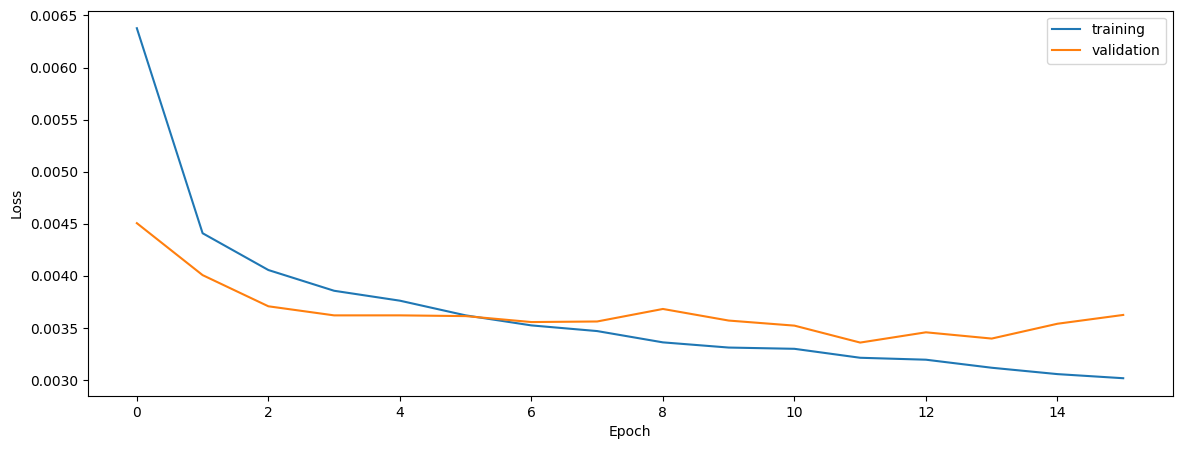

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8292900610660453
0.8024471096938149
0.806174888666792


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.8292900610660453
0.8024471096938149
0.806174888666792


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.832777806691825
0.8033609958639344
0.811752812752032


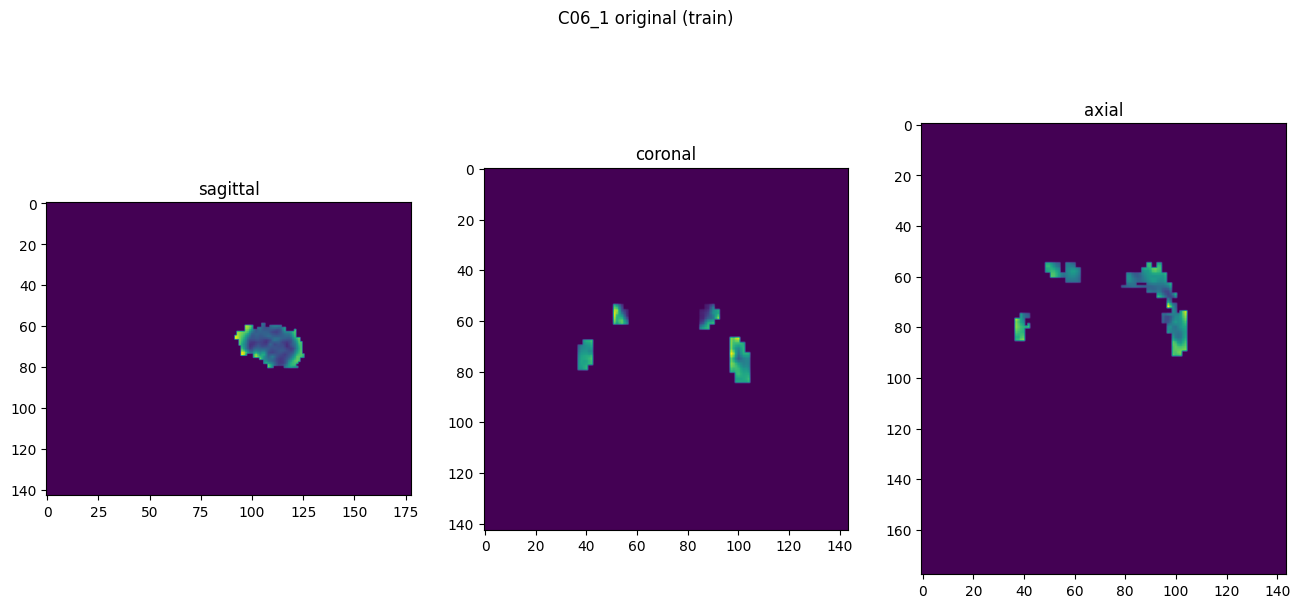

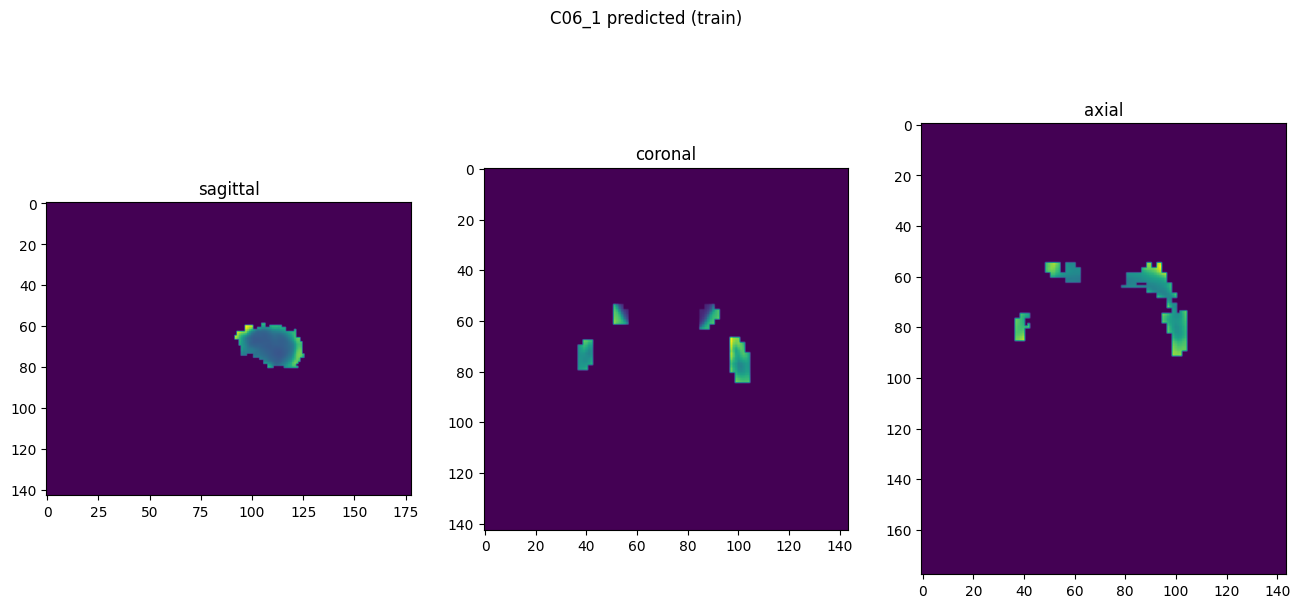

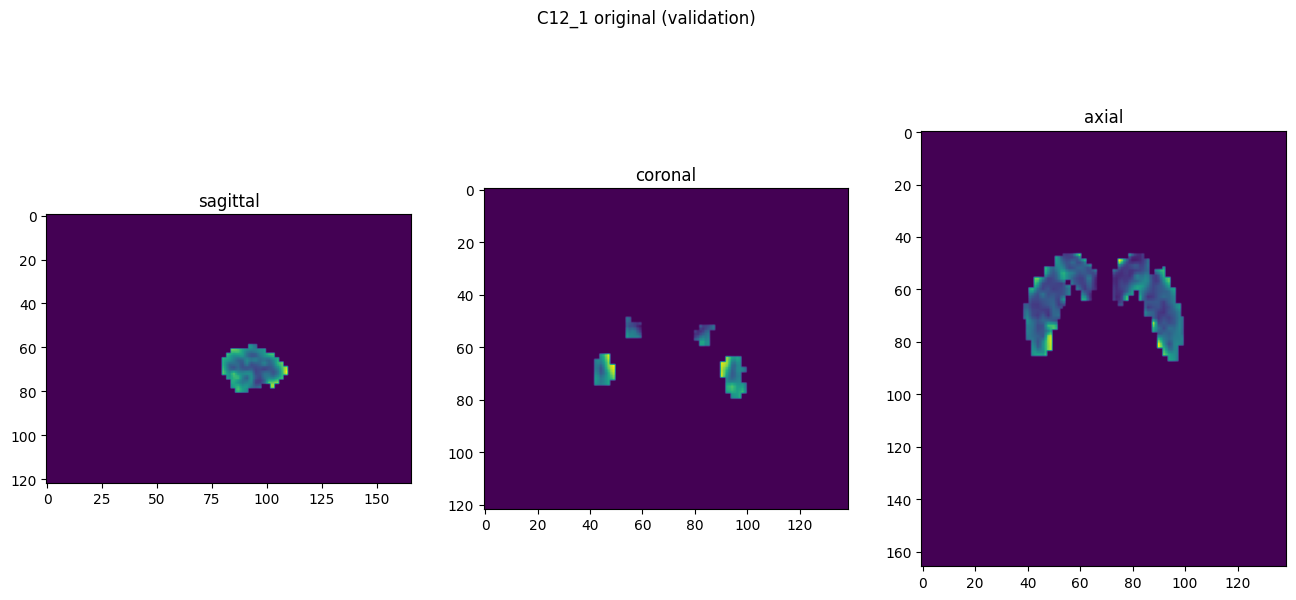

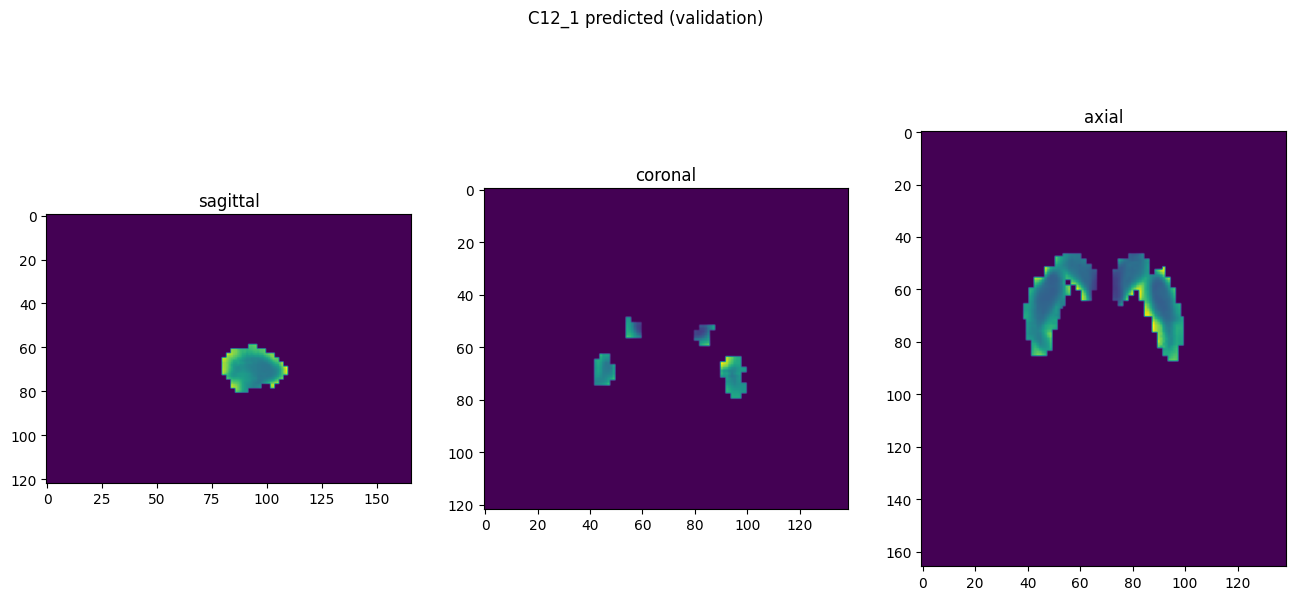

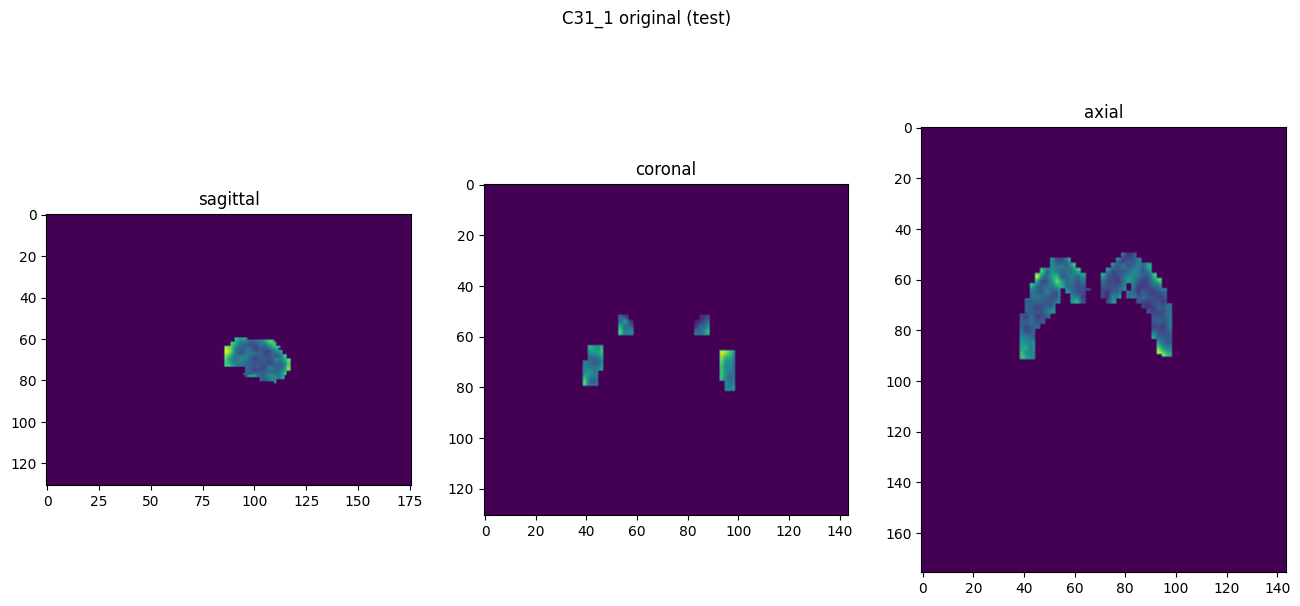

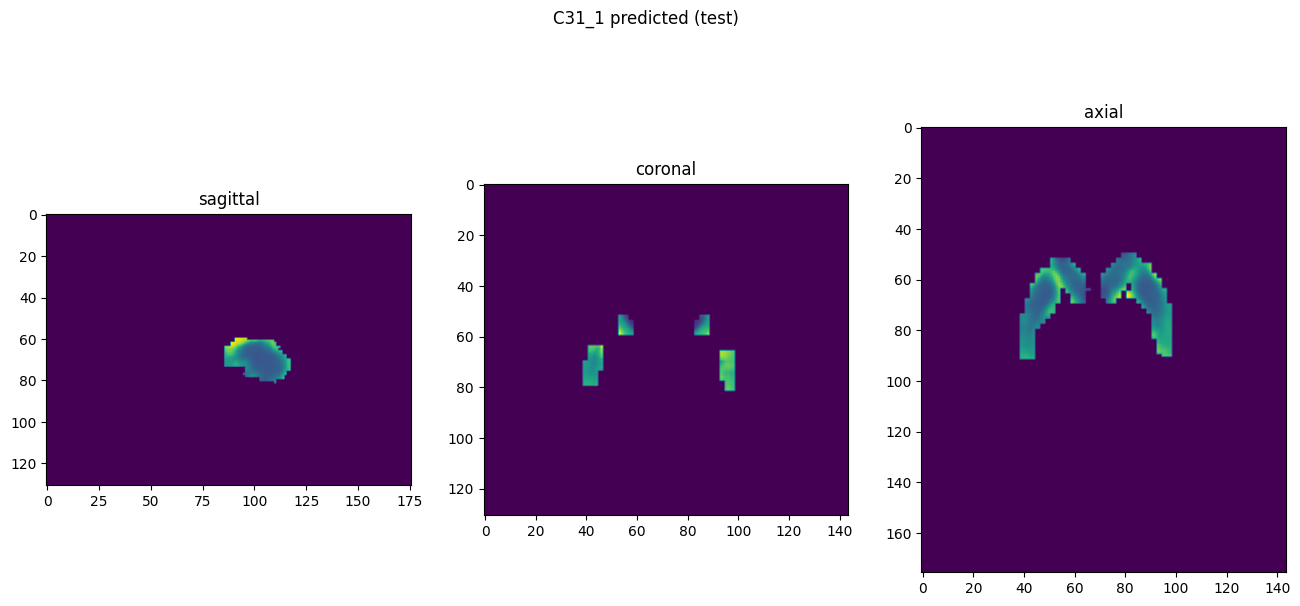

In [10]:
showResults(model, gen, threshold=None, background=False)